In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PowerTransformer, MinMaxScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
import sklearn.linear_model as linear

from imblearn.ensemble import BalancedBaggingClassifier

from catboost import CatBoostClassifier, Pool, cv

from tmpnn import Classification, L1, L2, Lyapunov1, Lyapunov2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import autograph
tf.keras.utils.set_random_seed(17)

def balanced_log_loss(y_true, p_pred):
    N0 = np.sum(1-y_true)
    N1 = np.sum(y_true)

    p0 = K.clip(p_pred[:,0]/p_pred.sum(1), 1e-15, 1 - 1e-15)
    p1 = K.clip(p_pred[:,1]/p_pred.sum(1), 1e-15, 1 - 1e-15)

    log_loss_0 = -np.sum((1-y_true) * np.log(p0)) / N0
    log_loss_1 = -np.sum(y_true * np.log(p1)) / N1
    return (log_loss_0 + log_loss_1)/2

def balanced_log_loss1(y_true, p_pred):
    N0 = np.sum(1-y_true)
    N1 = np.sum(y_true)

    p0 = np.clip((1-p_pred), 1e-15, 1 - 1e-15)
    p1 = np.clip(p_pred, 1e-15, 1 - 1e-15)

    log_loss_0 = -np.sum((1-y_true) * np.log(p0)) / N0
    log_loss_1 = -np.sum(y_true * np.log(p1)) / N1
    return (log_loss_0 + log_loss_1)/2

def blloss(p_true, p_pred):
    N0 = K.sum(p_true[:,0])
    N1 = K.sum(p_true[:,1])

    p0 = K.clip(p_pred[:,0]/K.sum(p_pred,1), 1e-15, 1 - 1e-15)
    p1 = K.clip(p_pred[:,1]/K.sum(p_pred,1), 1e-15, 1 - 1e-15)

    log_loss_0 = -K.sum(p_true[:,0] * K.log(p0)) / N0
    log_loss_1 = -K.sum(p_true[:,1] * K.log(p1)) / N1
    return (log_loss_0 + log_loss_1)/2
shifted_blloss=autograph.experimental.do_not_convert(lambda t,p: blloss(t+0.5,p+0.5))

def blloss1(p_true, p_pred):
    N0 = K.sum(1-p_true)
    N1 = K.sum(p_true)

    p0 = K.clip((1-p_pred), 1e-15, 1 - 1e-15)
    p1 = K.clip(p_pred, 1e-15, 1 - 1e-15)

    log_loss_0 = -K.sum((1-p_true) * K.log(p0)) / N0
    log_loss_1 = -K.sum(p_true * K.log(p1)) / N1
    return (log_loss_0 + log_loss_1)/2
shifted_blloss1=autograph.experimental.do_not_convert(lambda t,p: blloss1(t+0.5,p+0.5))

In [10]:
df = pd.read_csv('train.csv')
X, Y = df.drop(columns=['Id','Class']), np.asfarray(df['Class'])
X['EJ'] = LabelEncoder().fit_transform(X['EJ'])-0.5
for col in X.columns:
    na = X[col].isna()
    if na.any():
        X['n'+col] = np.asfarray(na)
X.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,nBQ,nCB,nCC,nDU,nEL,nFC,nFL,nFS,nGL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,0.5,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,-0.5,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,0.5,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,0.5,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,0.5,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=0.3, random_state=17)

pre = Pipeline([
    ('imp',KNNImputer()),
    ('pt',PowerTransformer()),
    ('mms',MinMaxScaler((-0.5,0.5)))
])
X_tr = pre.fit_transform(X_tr)
X_val = np.clip(pre.transform(X_val),-1,1)
X = np.clip(pre.transform(X),-1,1)

In [26]:
cat = CatBoostClassifier(verbose=False)
cat.fit(X_tr, Y_tr, eval_set=(X_val, Y_val))
print('train', balanced_log_loss(Y_tr, cat.predict_proba(X_tr)))
print('  val', balanced_log_loss(Y_val,cat.predict_proba(X_val)))

train 0.006607211763665274
  val 0.3516906706656897


In [42]:
reg = linear.RidgeCV()
p = PolynomialFeatures(3)
reg.fit(p.fit_transform(X_tr), Y_tr)
print('train', balanced_log_loss1(Y_tr, reg.predict(p.transform(X_tr))))
print('train', balanced_log_loss1(Y_val,reg.predict(p.transform(X_val))))

train 0.041251918135320906
train 0.2895386959837797


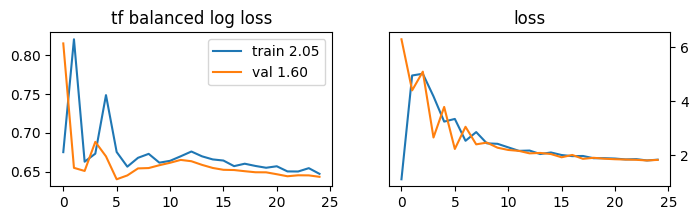

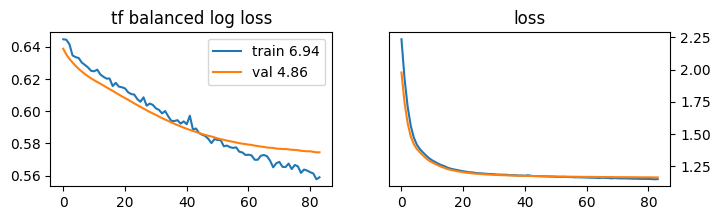

train 0.5605182993538234
  val 0.5745149415058012


In [23]:
# -0.5, 0.5 labels n=2
f=cat.get_feature_importance()>0
model = Classification(X[:,f].shape[1], 2, 2, 7, regularizer=L1())

model.set_learning_rate(5e-3, metrics=shifted_blloss, loss='mse')
history = model.fit(X_tr[:,f], np.column_stack([0.5-Y_tr, Y_tr-0.5]), epochs=25,
                     validation_data=(X_val[:,f], np.column_stack([0.5-Y_val,Y_val-0.5])))
plot(history, model, metric='<lambda>')
model.set_learning_rate(1e-4, metrics=shifted_blloss, loss=shifted_blloss)
history = model.fit(X_tr[:,f], np.column_stack([0.5-Y_tr, Y_tr-0.5]), epochs=100, stop_monitor='val_<lambda>', patience=0,
                     validation_data=(X_val[:,f], np.column_stack([0.5-Y_val,Y_val-0.5])))
plot(history, model, metric='<lambda>')
print('train', balanced_log_loss(Y_tr, model.predict_proba(X_tr[:,f])+0.5))
print('  val', balanced_log_loss(Y_val,model.predict_proba(X_val[:,f])+0.5))

In [8]:
#   0,   1 labels n=2
f=cat.get_feature_importance()>1
model = Classification(X[:,f].shape[1], 2, 2, 7, regularizer=L1())

model.set_learning_rate(5e-3, metrics=blloss, loss='mse')
history = model.fit(X_tr[:,f], np.column_stack([1-Y_tr,Y_tr]), epochs=100, stop_monitor='val_blloss', patience=10,
                     validation_data=(X_val[:,f], np.column_stack([1-Y_val,Y_val])))
model.set_learning_rate(5e-5, metrics=blloss, loss=blloss)
history = model.fit(X_tr[:,f], np.column_stack([1-Y_tr,Y_tr]), epochs=100, stop_monitor='val_blloss', patience=0,
                     validation_data=(X_val[:,f], np.column_stack([1-Y_val,Y_val])))
print('train', balanced_log_loss(Y_tr, model.predict_proba(X_tr[:,f])))
print('  val', balanced_log_loss(Y_val,model.predict_proba(X_val[:,f])))

train 0.2773361898712937
  val 0.3625215360090581


In [9]:
# -0.5, 0.5 labels n=1
f=cat.get_feature_importance()>1
model = Classification(X[:,f].shape[1], 1, 2, 7, regularizer=L1())

model.set_learning_rate(5e-3, metrics=shifted_blloss1, loss='mse')
history = model.fit(X_tr[:,f], Y_tr.reshape(-1,1)-0.5, epochs=100, stop_monitor='val_<lambda>', patience=10,
                     validation_data=(X_val[:,f], Y_val.reshape(-1,1)-0.5))
model.set_learning_rate(5e-5, metrics=shifted_blloss1, loss=shifted_blloss1)
history = model.fit(X_tr[:,f], Y_tr.reshape(-1,1)-0.5, epochs=100, stop_monitor='val_<lambda>', patience=0,
                     validation_data=(X_val[:,f], Y_val.reshape(-1,1)-0.5))
print('train', balanced_log_loss1(Y_tr, model.predict_proba(X_tr[:,f])[:,1]+0.5))
print('  val', balanced_log_loss1(Y_val,model.predict_proba(X_val[:,f])[:,1]+0.5))

train 0.6052484417322435
  val 0.5811662316465607


In [10]:
# 0, 1 labels n=1
f=cat.get_feature_importance()>1
model = Classification(X[:,f].shape[1], 1, 2, 7, regularizer=L1())

model.set_learning_rate(5e-3, metrics=blloss1, loss='mse')
history = model.fit(X_tr[:,f], Y_tr.reshape(-1,1), epochs=100, stop_monitor='val_blloss1', patience=10,
                     validation_data=(X_val[:,f], Y_val.reshape(-1,1)))
model.set_learning_rate(5e-5, metrics=blloss1, loss=blloss1)
history = model.fit(X_tr[:,f], Y_tr.reshape(-1,1), epochs=100, stop_monitor='val_blloss1', patience=0,
                     validation_data=(X_val[:,f], Y_val.reshape(-1,1)))
print('train', balanced_log_loss(Y_tr, model.predict_proba(X_tr[:,f])))
print('  val', balanced_log_loss(Y_val,model.predict_proba(X_val[:,f])))

train 0.15536975909089173
  val 0.29662777794354833


# submit

In [34]:
f=np.array([ True,  True, False,  True, False, False, False, False,  True,
            False, False, False,  True, False, False,  True,  True,  True,
            False, False, False,  True,  True, False, False,  True,  True,
            False,  True,  True,  True,  True,  True, False,  True,  True,
             True,  True, False, False,  True, False,  True,  True,  True,
             True,  True,  True,  True, False, False,  True,  True,  True,
            False,  True])
f.sum()

33

In [5]:
df = pd.read_csv('train.csv')
df = df.fillna(df.mean(numeric_only=True))
X, Y = df.drop(columns=['Id','Class']), np.asfarray(df['Class'])

le = LabelEncoder()
pt = PowerTransformer()
mms = MinMaxScaler((-0.5,0.5))

X['EJ'] = le.fit_transform(X['EJ'])-0.5
X = mms.fit_transform(pt.fit_transform(X))

In [76]:
import tensorflow as tf
tf.keras.utils.set_random_seed(0)
from tensorflow import autograph
shifted_blloss=autograph.experimental.do_not_convert(lambda t,p: blloss(t+0.5,p+0.5))

In [131]:
model = Classification(X[:,f].shape[1], 2, 2, 7, verbose=0, regularizer=L1())
model.set_learning_rate(5e-3, metrics=shifted_blloss, loss='mse')
history = model.fit(X[:,f], np.column_stack([0.5-Y, Y-0.5]), epochs=100)
model.set_learning_rate(5e-5, metrics=shifted_blloss, loss=shifted_blloss)
history = model.fit(X[:,f], np.column_stack([0.5-Y, Y-0.5]), epochs=100)
balanced_log_loss(Y, model.predict_proba(X[:,f])+0.5)

0.11676100528982172

In [110]:
pd.DataFrame(np.vstack(model.pnn.get_weights())).to_csv('weights.csv',index=False)

In [6]:
weights = pd.read_csv('weights.csv').values
W = (weights[0], weights[1:f.sum()+3], weights[f.sum()+3:])

def tm_map(x, weights=None, steps=7):
    W0, W1, W2 = weights
    ans = np.asfarray(np.hstack((x, np.zeros((x.shape[0], 2)))))
    for _ in range(steps):
        ans = W0 + np.dot(ans, W1) + np.dot((ans[:,:,None]*ans[:,None,:]).reshape(ans.shape[0],-1), W2)
    return ans[:,-2:]+0.5

In [33]:
def score(y_true, p_pred):
    N0 = np.sum(1 - y_true)
    N1 = np.sum(y_true)

    p0 = K.clip(p_pred[:,0]/p_pred.sum(1), 1e-15, 1 - 1e-15)
    p1 = K.clip(p_pred[:,1]/p_pred.sum(1), 1e-15, 1 - 1e-15)

    log_loss_0 = -np.sum((1 - y_true) * np.log(p0)) / N0
    log_loss_1 = -np.sum(y_true * np.log(p1)) / N1
    return (log_loss_0 + log_loss_1)/2
pred = tm_map(X[:,f], W)
pred[0]/=pred.sum()
pred[1]/=pred.sum()
score(Y, np.clip((pred),0,1))

0.11676100684587581

In [8]:
test = pd.read_csv('test.csv')
X_test = test.fillna(df.mean(numeric_only=True)).drop(columns=['Id'])
X_test['EJ'] = le.transform(X_test['EJ'])-0.5
X_test = mms.transform(pt.transform(X_test))
submit = test[['Id']].copy()

In [20]:
pred = tm_map(np.clip(X_test[:,f], -1, 1), W)
submit["class_0"] = pred[:,0]/pred.sum(1)
submit["class_1"] = pred[:,1]/pred.sum(1)
submit=submit.fillna(0.5)
# submit.to_csv('/kaggle/working/submission.csv',index=False)
submit

,Id,class_0,class_1
0,00eed32682bb,-0.170132,1.170132
1,010ebe33f668,-0.170132,1.170132
2,02fa521e1838,-0.170132,1.170132
3,040e15f562a2,-0.170132,1.170132
4,046e85c7cc7f,-0.170132,1.170132


In [18]:
pred = np.clip( tm_map(np.clip(X_test[:,f],-1, 1), W) ,0,1)
submit["class_0"] = pred[:,0]/pred.sum(axis=1)
submit["class_1"] = pred[:,1]/pred.sum(axis=1)
submit=submit.fillna(0.5)
# submit.to_csv('/kaggle/working/submission.csv',index=False)
submit

,Id,class_0,class_1
0,00eed32682bb,1.0,0.0
1,010ebe33f668,1.0,0.0
2,02fa521e1838,1.0,0.0
3,040e15f562a2,1.0,0.0
4,046e85c7cc7f,1.0,0.0


# legacy plot

In [16]:
def plot(history, model_=None, pred=None, metric='blloss'):
    plt.figure(figsize=(8,2))

    ax = plt.subplot(121)
    ax.set_title('tf balanced log loss')
    if model_:
        label_tr=f'train {balanced_log_loss(Y_tr, model_.predict_proba(X_tr)):.2f}'
        label_val=f'val {balanced_log_loss(Y_val, model_.predict_proba(X_val)):.2f}'
    elif pred:
        label_tr=f'train {balanced_log_loss(Y_tr, pred[0]):.2f}'
        label_val=f'val {balanced_log_loss(Y_val, pred[1]):.2f}'
    else:
        label_tr='train'
        label_val='val'
    ax.plot(history.history[metric], label=label_tr)
    ax.plot(history.history['val_'+metric], label=label_val)
    ax.legend()

    ax = plt.subplot(122)
    ax.set_title('loss')
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.yaxis.tick_right()

    plt.show()